In [1]:
import numpy as np
from PIL import Image
from pathlib import Path
import pandas as pd
from skimage import io
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from skimage.io import imread
from tifffile import imwrite, imsave
import matplotlib as mpl
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
mpl.rcParams['figure.dpi'] = 200
params = {'mathtext.default': 'regular','font.family':'Helvetica','font.size': 12 }          
plt.rcParams.update(params)

This workbook is the first workbook I used to calculate the cosine similarity statistics for the Ni22Cr hyperspectral images from Lund.  It also contains the statistical testing an violin plots for the publication

In [2]:
def cosine_similarity_3d(image,reference):
    """Take the cosine similarity of a hyperspectral image and a reference spectra of the same dimensions"""
    flat_image = (image.reshape((len(image),image.shape[1]*image.shape[2])).T)
    #Take the magnitude of each observation m for use in the cosine calculation
    norm = np.linalg.norm(flat_image, axis=1)
    #Calculate cosine similarity using CS = a.b/(||a||*||b||)
    cosine = np.dot(flat_image,reference)/(norm*np.linalg.norm(reference))
    #reshape the cosine sum into a 2d image
    cosine_2d = cosine.reshape((image.shape[1],image.shape[2]))
    return cosine_2d

def normed_cs_metal_ox(image, ref1, ref2):
    #performs the normalized cosine similarity using the metal and oxide refs, does not deal with NAN's
    image = image[:len(ref1),:,:]
    metal_cs = cosine_similarity_3d(image, ref1)
    oxide_cs = cosine_similarity_3d(image, ref2)
    cosine_sum = metal_cs+oxide_cs
    oxide_cosine_norm = oxide_cs/cosine_sum
    return oxide_cosine_norm
   


In [3]:
#Read .csv files containing energy, intensity values for reference spectra
metal_ref_data = pd.read_csv("/Users/apple/Sync/Research/maxPEEM - Ni-22Cr/Cr_xas_Ledge_metal_reference.csv",header=None,names=("energy","intensity"))
oxide_ref_data = pd.read_csv("/Users/apple/Sync/Research/maxPEEM - Ni-22Cr/Cr_xas_Ledge_oxide_reference.csv",header=None,names=("energy","intensity"))

#Prepare data and sort (not necessary if using smooth reference spectra)
metal_ref_data = metal_ref_data.drop_duplicates(subset=["energy"])
metal_ref_data = metal_ref_data.sort_values(by=["energy"])
oxide_ref_data = oxide_ref_data.drop_duplicates(subset=["energy"])
oxide_ref_data = oxide_ref_data.sort_values(by=["energy"])

#Do cubic interpolation on the reference spectra so that any energy/step size can be made compatible with experimental spectra
metal_ref_interp = CubicSpline(metal_ref_data["energy"],metal_ref_data["intensity"])
oxide_ref_interp = CubicSpline(oxide_ref_data["energy"],oxide_ref_data["intensity"])

#Calculate a vector reference spectra with the same start, finish, and step size as the experiment
#xrange = np.arange(570,584.2,0.2)
xrange = np.arange(570,584.2,0.2)
metal_ref = metal_ref_interp(xrange)
metal_ref = (metal_ref-min(metal_ref))/(max(metal_ref)-min(metal_ref))
oxide_ref = oxide_ref_interp(xrange)
oxide_ref = (oxide_ref-min(oxide_ref))/(max(oxide_ref)-min(oxide_ref))
print(metal_ref.shape)

(72,)


In [4]:
np.savetxt("metal_ref_570-590.csv",metal_ref,delimiter=',')
np.savetxt("oxide_ref_570-590.csv",oxide_ref,delimiter=',')

Text(0, 0.5, 'Intensity (arb. u.)')

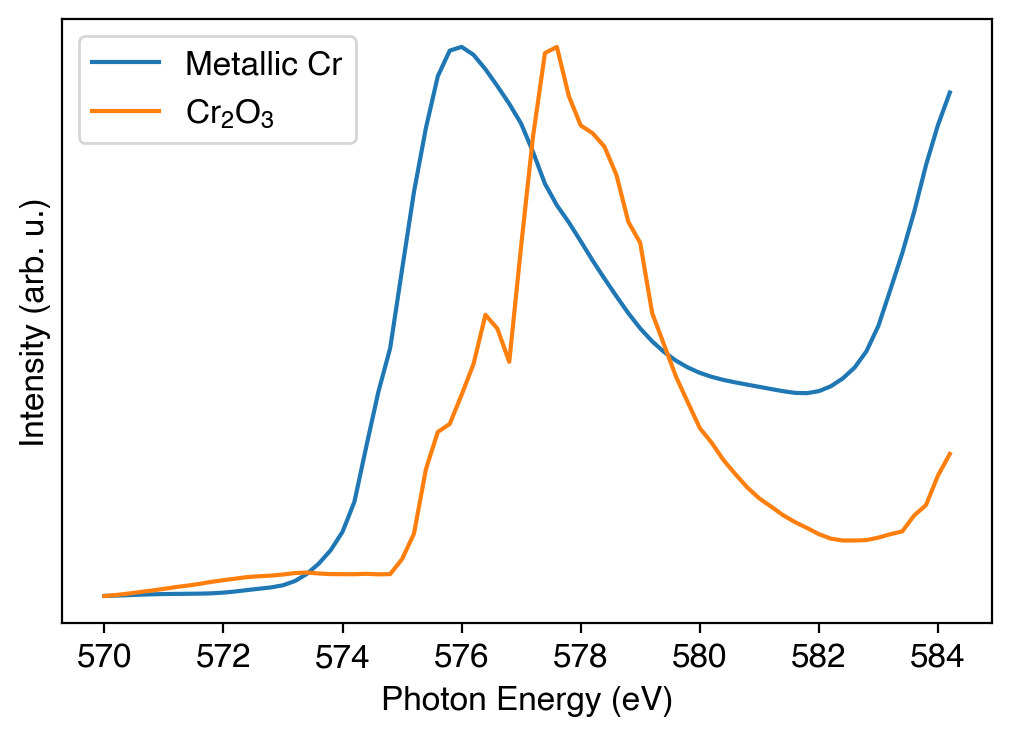

In [5]:
#Visualize the metal and oxide reference spectra
plt.plot(xrange, metal_ref)
plt.plot(xrange, oxide_ref)
plt.legend(("Metallic Cr","$Cr_{2}O_{3}$"))
plt.yticks([])
plt.xlabel("Photon Energy (eV)")
plt.ylabel("Intensity (arb. u.)")

In [6]:
#Read in the hyperspectral image
cr45L = io.imread("/Users/apple/Sync/Research/maxPEEM - Ni-22Cr/3rd_oxidation_45L/normed_45L-Cr XAS 570-595 step0p2.tif")
#cr45L = io.imread("/Users/apple/Sync/Research/NiCr XPEEM/Cluster Analysis/metal_xas.tif")
#cr45L = io.imread("/Users/apple/Sync/Research/NiCr XPEEM/Cluster Analysis/particle_xas.tif")


#Only include the L2 edge, as there's some experimental artifacts in the L3 edge
cr45L = cr45L[:72,:,:]
print(cr45L.shape)


(72, 512, 512)


In [8]:
#reshape the image into (m x n) where m is observations and n is variables
flat_cr45L = (cr45L.reshape((len(cr45L),cr45L.shape[1]*cr45L.shape[2])).T)
print(flat_cr45L.shape)
#Take the magnitude of each observation m for use in the cosine calculation
norm = np.linalg.norm(flat_cr45L, axis=1)
print(norm.shape)
#Calculate cosine similarity using CS = a.b/(||a||*||b||)
oxide_cosine = np.dot(flat_cr45L,oxide_ref)/(norm*np.linalg.norm(oxide_ref))
metal_cosine = np.dot(flat_cr45L, metal_ref)/(norm*np.linalg.norm(metal_ref))
#Normalize the total cosine score from 0-1 by adding the oxide and metal scores together
cosine_sum_img = oxide_cosine+metal_cosine
oxide_cosine_norm = oxide_cosine/cosine_sum_img
metal_cosine_norm = metal_cosine/cosine_sum_img

(262144, 72)
(262144,)


<ipython-input-8-90c597446ff3>:8: RuntimeWarning: invalid value encountered in true_divide
  oxide_cosine = np.dot(flat_cr45L,oxide_ref)/(norm*np.linalg.norm(oxide_ref))
<ipython-input-8-90c597446ff3>:9: RuntimeWarning: invalid value encountered in true_divide
  metal_cosine = np.dot(flat_cr45L, metal_ref)/(norm*np.linalg.norm(metal_ref))


Calculations in cosine_similarity_brookhaven approximate the linear combination percent from the noramalized cosine similarity

In [9]:
params = [-30.69006309,  40.12087749, -11.80374623]
oxide_cs_to_percent = np.poly1d(params)

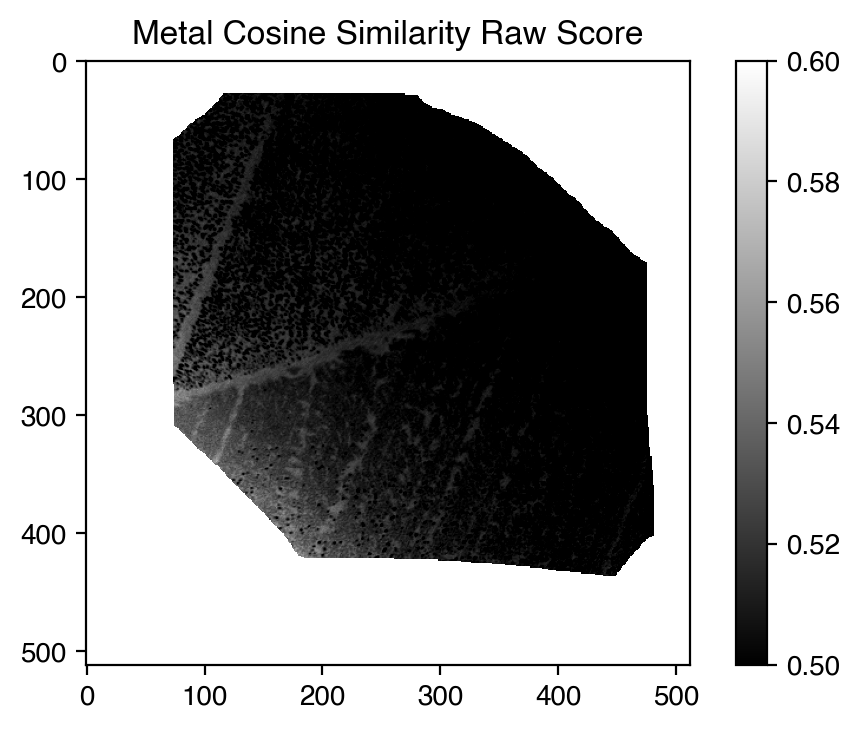

In [10]:
#plot the normalized cosine similarity for metal, and save an image 
# params = {"ytick.color" : "w",
#           "xtick.color" : "w",
#           "axes.labelcolor" : "w",
#           "axes.edgecolor" : "w"}

plt.imshow(metal_cosine_norm.reshape((cr45L.shape[1],cr45L.shape[2])),cmap='gray',vmin=.5,vmax=.6)
plt.title("Metal Cosine Similarity Raw Score")
plt.colorbar()
metal_cosine_img = 32767*np.nan_to_num(metal_cosine_norm.reshape((cr45L.shape[1],cr45L.shape[2])))

#imsave("metal_cosine_score.tif", metal_cosine_img.astype(np.int16))

nan


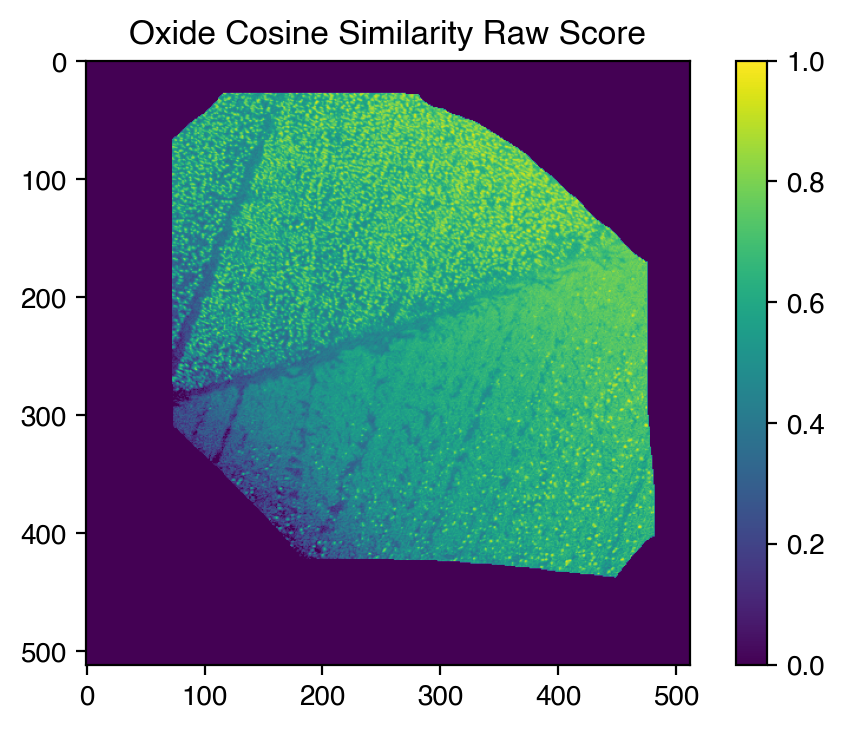

In [11]:
# #plot the normalizee cosine similarity for oxide, and save an image
# params = {"ytick.color" : "w",
#           "xtick.color" : "w",
#           "axes.labelcolor" : "w",
#           "axes.edgecolor" : "w"}
# plt.rcParams.update(params)
img = oxide_cs_to_percent(oxide_cosine_norm.reshape((cr45L.shape[1],cr45L.shape[2])))
mask = (img < 1)
print(mask[0,0]*img[0,0])
plt.imshow(np.nan_to_num(img*mask,0), cmap='viridis',vmin=0,vmax=1)

#plt.imshow(oxide_cosine_norm.reshape((cr45L.shape[1],cr45L.shape[2])), cmap='gray',vmax=.5,vmin=.4)


plt.title("Oxide Cosine Similarity Raw Score")
plt.colorbar()
oxide_cosine_img = 32767*np.nan_to_num(oxide_cosine_norm.reshape((cr45L.shape[1],cr45L.shape[2])))
#imsave("oxide_cosine_score.tif", oxide_cosine_img.astype(np.int16))

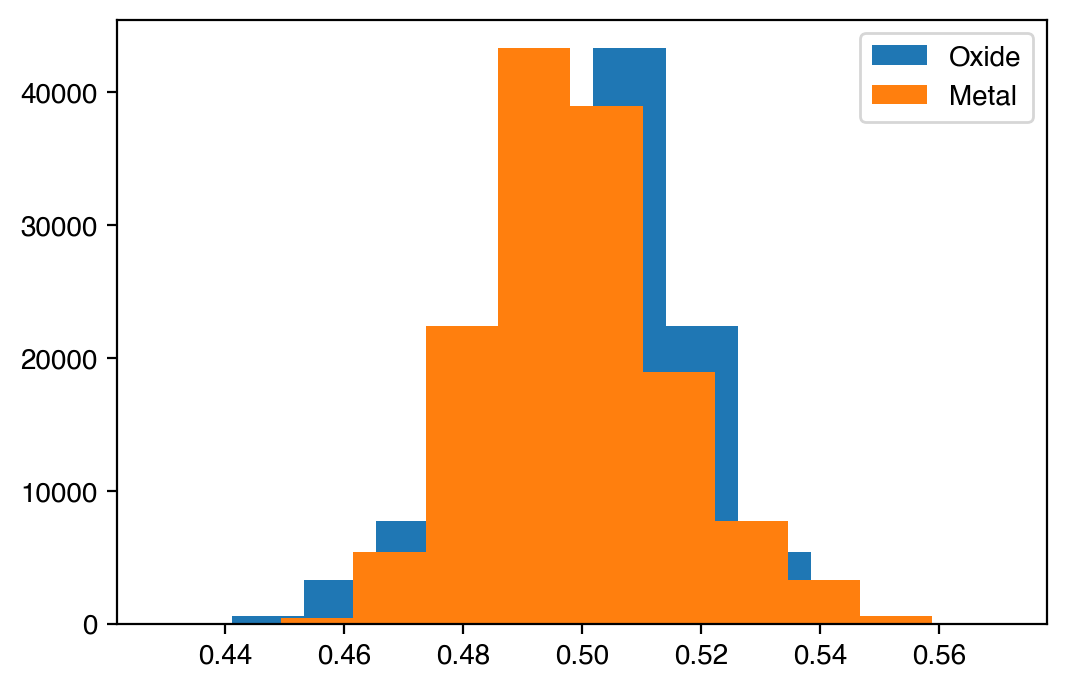

In [12]:
plt.hist(oxide_cosine_norm)
plt.hist(metal_cosine_norm)
plt.legend(["Oxide", "Metal"])

Find the cosine similarity map of the earlier oxidation time steps

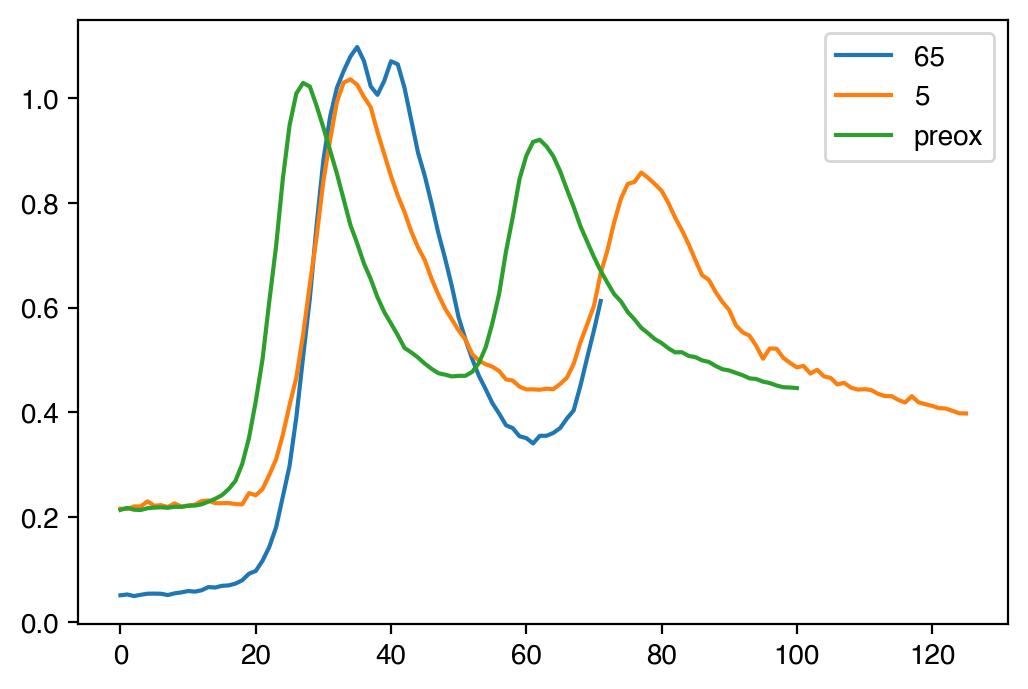

In [13]:
cr20 = io.imread("/Users/apple/Sync/Research/maxPEEM - Ni-22Cr/2nd_oxidation _15L/15L-CrXAS-movie@577-2.5eV-adjusted.tif")
cr5 = io.imread("/Users/apple/Sync/Research/maxPEEM - Ni-22Cr/XAS-alighned-tiff/5L-Cr XAS 570-595 step0p2-1_adjusted.tif")
cr0 = io.imread("/Users/apple/Sync/Research/maxPEEM - Ni-22Cr/XAS-alighned-tiff/XAS_pre-ox_Cr.tif")


plt.plot(np.average(cr45L,axis=(1,2))/26000)
#plt.plot((np.average(cr20,axis=(1,2))-5500)/400)
plt.plot(np.average(cr5,axis=(1,2))/500)
plt.plot(np.average(cr0,axis=(1,2))/1300)
#plt.plot(metal_ref)
#plt.plot(oxide_ref)
plt.legend(["65","5","preox","metal ref","oxide ref"])



In [15]:
# #exclude nan's from the violin plot
# cr20_ox_cs = normed_cs_metal_ox(cr20[2:,:,:], metal_ref,oxide_ref)
# cr5_ox_cs = normed_cs_metal_ox(cr5[2:,:,:],metal_ref,oxide_ref)
# cr0_ox_cs = normed_cs_metal_ox(cr0,metal_ref[2:],oxide_ref[2:])

# cr20_ox_cs = cr20_ox_cs.all(~np.isnan(cr20_ox_cs), cr20_ox_cs>.448, cr20_ox_cs<.552)
# cr5_ox_cs = cr5_ox_cs[~np.isnan(cr5_ox_cs)]
# cr0_ox_cs = cr0_ox_cs[~np.isnan(cr0_ox_cs)]

In [16]:
cr20_ox_cs = cr20_ox_cs[~np.isnan(cr20_ox_cs)]
cr5_ox_cs = cr5_ox_cs[~np.isnan(cr5_ox_cs)]
cr0_ox_cs = cr0_ox_cs[~np.isnan(cr0_ox_cs)]

In [17]:
# fig1, ax1 = plt.subplots(figsize=(4,3))
# fig1 = sns.violinplot(data= [oxide_cs_to_percent(cr20_ox_cs), oxide_cs_to_percent(cr5_ox_cs),oxide_cs_to_percent(cr0_ox_cs)],orient='h')
# # sns.despine(left=True)
# # sns.set_style("whitegrid")
# ax1.set_yticklabels(['20 L',"5 L", "Pre-oxidation"])
# ax1.tick_params(direction='in')
# #ax1.grid(axis='x')
# plt.xlabel("CS converted to linear combination")

Find the difference between the islands and the background

<ipython-input-3-1f2c88a7fcd6>:7: RuntimeWarning: invalid value encountered in true_divide
  cosine = np.dot(flat_image,reference)/(norm*np.linalg.norm(reference))


(array([4.3600e+02, 3.5220e+03, 1.2234e+04, 2.3842e+04, 2.9164e+04,
        2.0836e+04, 8.7860e+03, 2.2530e+03, 1.8600e+02, 1.3000e+01]),
 array([0.46213512, 0.4689167 , 0.47569829, 0.48247987, 0.48926145,
        0.49604303, 0.50282461, 0.50960619, 0.51638777, 0.52316935,
        0.52995093]),
 <BarContainer object of 10 artists>)

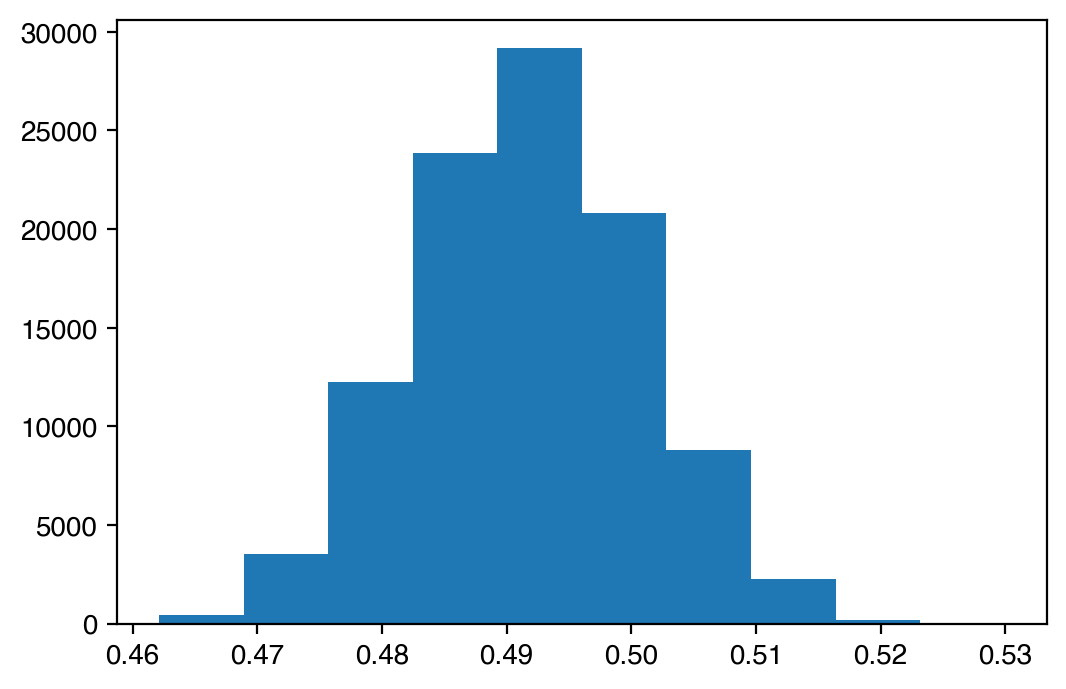

In [18]:
#Find the statistics for CS of the islands and the background

background = io.imread("/Users/apple/Sync/Research/NiCr XPEEM/Cluster Analysis/metal_xas.tif")
islands = io.imread("/Users/apple/Sync/Research/NiCr XPEEM/Cluster Analysis/particle_xas.tif")

br_oxide_cosine = cosine_similarity_3d(background[:72,:,:],oxide_ref)
br_metal_cosine = cosine_similarity_3d(background[:72,:,:],metal_ref)
#Normalize the total cosine score from 0-1 by adding the oxide and metal scores together
br_cosine_sum_img = br_oxide_cosine+br_metal_cosine
br_oxide_cosine_norm = br_oxide_cosine/br_cosine_sum_img
br_metal_cosine_norm = br_oxide_cosine/br_cosine_sum_img

br_oxide_cosine_norm = br_oxide_cosine_norm[~np.isnan(br_oxide_cosine_norm)]
plt.hist(br_oxide_cosine_norm)


<ipython-input-3-1f2c88a7fcd6>:7: RuntimeWarning: invalid value encountered in true_divide
  cosine = np.dot(flat_image,reference)/(norm*np.linalg.norm(reference))


(array([  62.,  220.,  586., 1303., 4050., 6054., 4543., 2229.,  584.,
          44.]),
 array([0.46999224, 0.47633006, 0.48266789, 0.48900572, 0.49534355,
        0.50168138, 0.5080192 , 0.51435703, 0.52069486, 0.52703269,
        0.53337051]),
 <BarContainer object of 10 artists>)

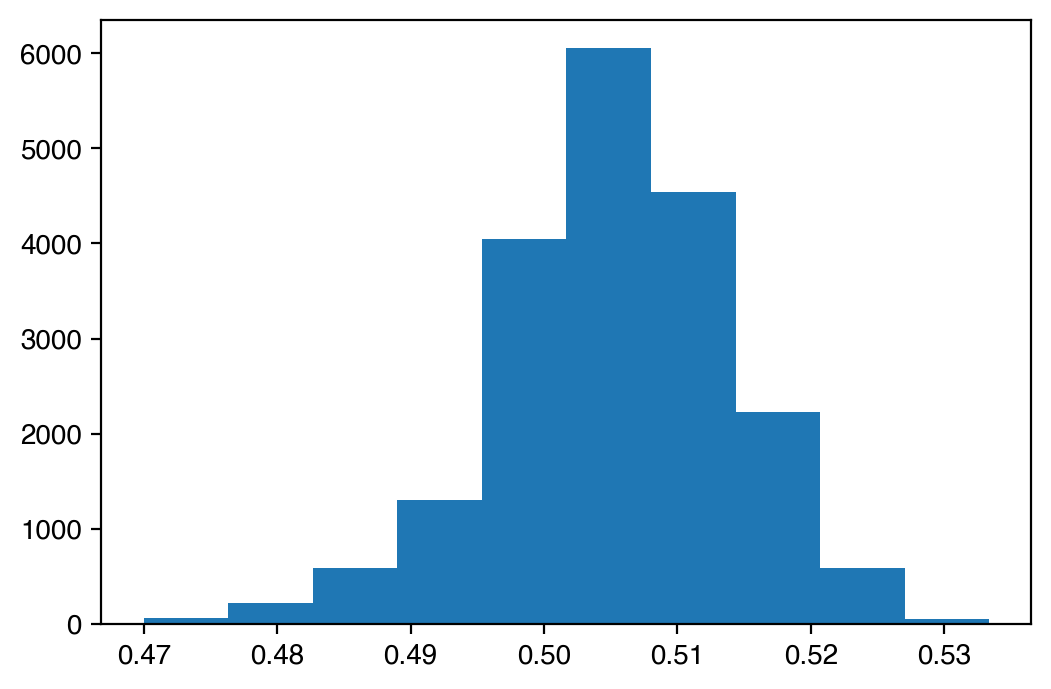

In [19]:
is_oxide_cosine = cosine_similarity_3d(islands[:72,:,:],oxide_ref)
is_metal_cosine = cosine_similarity_3d(islands[:72,:,:],metal_ref)
is_cosine_sum_img = is_oxide_cosine+is_metal_cosine
is_oxide_cosine_norm = is_oxide_cosine/is_cosine_sum_img
is_metal_cosine_norm = is_oxide_cosine/is_cosine_sum_img

is_oxide_cosine_norm = is_oxide_cosine_norm[~np.isnan(is_oxide_cosine_norm)]
plt.hist(is_oxide_cosine_norm)

Perform statistical testing

In [20]:
from scipy.stats import f_oneway, ttest_ind, iqr
print(np.average(is_oxide_cosine_norm), np.average(br_oxide_cosine_norm))
print(len(is_oxide_cosine_norm), len(br_oxide_cosine_norm))
#Calculate the anova statistic and pvalue comparing the CS_islands.oxide to the CS_background.oxide
f, pval = ttest_ind(is_oxide_cosine_norm,br_oxide_cosine_norm)
print(f, pval)
print(np.percentile(is_oxide_cosine_norm,25),np.percentile(br_oxide_cosine_norm,75))

0.5053184818765443 0.4916717745791986
19675 101272
194.60869093807122 0.0
0.5002460444922012 0.49781668937081


Text(0.5, 0, 'Calculated oxide fraction')

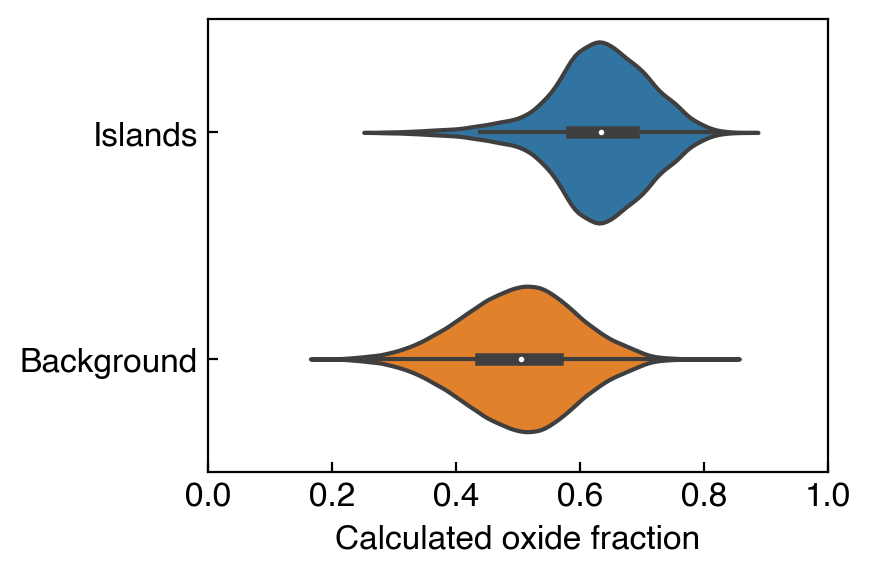

In [32]:

fig1, ax1 = plt.subplots(figsize=(4,3))
fig1 = sns.violinplot(data= [oxide_cs_to_percent(is_oxide_cosine_norm), oxide_cs_to_percent(br_oxide_cosine_norm)],orient='h')
# sns.despine(left=True)
# sns.set_style("whitegrid")
ax1.set_yticklabels(['Islands',"Background"])
ax1.tick_params(direction='in')
plt.xlim((0,1))
#ax1.grid(axis='x')

plt.xlabel("Calculated oxide fraction")




(array([6.34842773e-01, 5.12824827e+00, 1.78134552e+01, 3.47154160e+01,
        4.24645748e+01, 3.03384955e+01, 1.27929555e+01, 3.28050635e+00,
        2.70827422e-01, 1.89287983e-02]),
 array([0.46213512, 0.4689167 , 0.47569829, 0.48247987, 0.48926145,
        0.49604303, 0.50282461, 0.50960619, 0.51638777, 0.52316935,
        0.52995093]),
 <BarContainer object of 10 artists>)

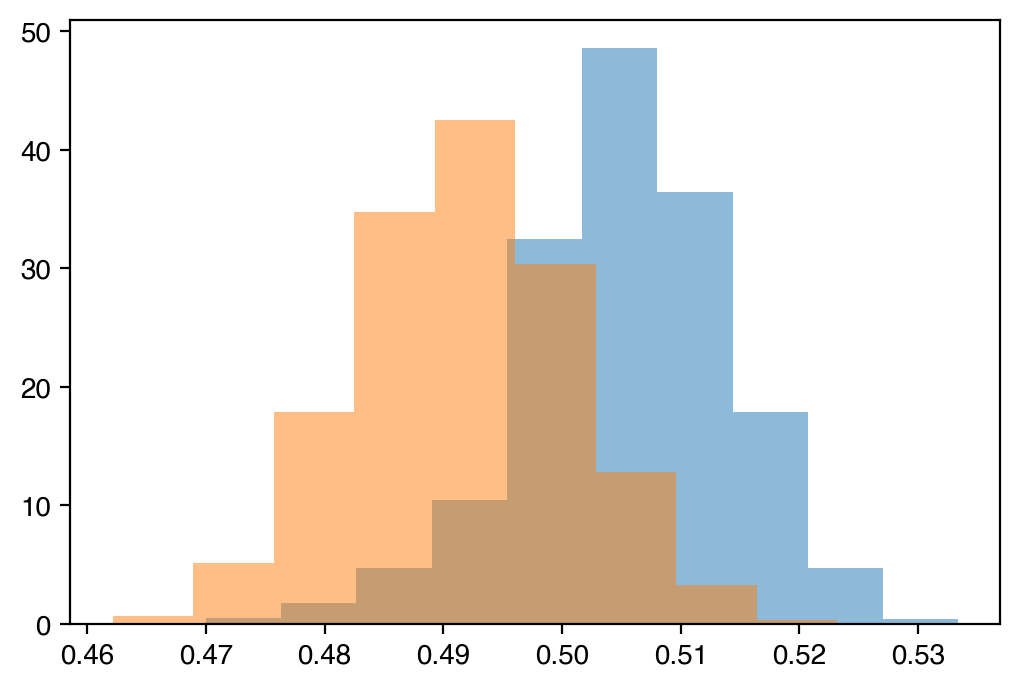

In [22]:
plt.hist(is_oxide_cosine_norm,density=True,alpha=0.5)
plt.hist(br_oxide_cosine_norm,density=True,alpha=0.5)

